# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [9]:
from dps_lake_model import (lake_model, get_antropogenic_release)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, util)

from ema_workbench import save_results, load_results


from ema_workbench.analysis import parcoords

from ema_workbench import Policy

from ema_workbench import perform_experiments

from ema_workbench.util import ema_logging

import os



In [10]:
fn = './results/selected_results.tar.gz'

results = load_results(fn)
experiments, outcomes = results

In [11]:
results1 = results[1]['utility']
worst_four = sorted(results1)[0:4]

In [12]:
worst_four

[0.1190801466164452, 0.1195001375637349, 0.1213207004482429, 0.121676939091453]

In [13]:
results

(             b     delta      mean         q     stdev        c1        c2  \
 0     0.273515  0.977410  0.045615  3.786011  0.001710  0.125158  0.272257   
 1     0.247986  0.971721  0.037351  4.209994  0.004012  0.125158  0.272257   
 2     0.133090  0.965256  0.010909  4.053383  0.003768  0.125158  0.272257   
 3     0.204798  0.972639  0.032819  3.917798  0.003090  0.125158  0.272257   
 4     0.366422  0.931671  0.036192  2.414730  0.001717  0.125158  0.272257   
 ...        ...       ...       ...       ...       ...       ...       ...   
 5429  0.131182  0.947625  0.013143  4.179405  0.001012 -0.013216  0.241165   
 5430  0.108070  0.934070  0.016255  3.323201  0.002825 -0.013216  0.241165   
 5431  0.119168  0.938522  0.023876  4.092952  0.002137 -0.013216  0.241165   
 5432  0.184394  0.932155  0.035866  4.491360  0.001152 -0.013216  0.241165   
 5433  0.286991  0.955982  0.049906  4.255987  0.003639 -0.013216  0.241165   
 
             r1        r2        w1  scenario     

In [14]:
results[1]['utility'][0]

0.228631538295948

In [15]:
#for policy in results[0].policy.unique():

    
x=results[0].groupby(['scenario']).mean()

In [16]:
utility_dict = {}
for i in experiments["scenario"].unique():
    temp_df = experiments[experiments["scenario"] == i]
    temp_dict = {k:v[temp_df.index] for k,v in outcomes.items()}

    utility_mean = temp_dict["utility"].mean()
    utility_dict[i] = utility_mean

In [17]:
len(experiments['scenario'].unique())

444

In [18]:
len(utility_dict)

444

In [19]:
a = sorted(utility_dict.items(), key=lambda x: x[1]) 

In [20]:
worst_four = a[0:4]

In [21]:
left_over = experiments.loc[experiments["scenario"].isin([563,151,984,194])]
left_over.drop_duplicates(inplace=True, subset=['scenario'])

C:\Users\archipel-03\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
left_over = left_over[['b', 'delta', 'mean', 'q', 'stdev']]

In [23]:
left_over

,b,delta,mean,q,stdev
699,0.433739,0.941348,0.046417,4.463404,0.002574
864,0.422010,0.936846,0.041228,4.363879,0.002887
3677,0.139863,0.936962,0.016815,3.860961,0.004577
4197,0.268890,0.939461,0.013027,2.254826,0.002868


In [25]:
uncertainties = left_over.to_dict(orient='records')

from ema_workbench import Scenario

reference = []
for i in range(len(uncertainties)):
    reference.append(Scenario(str(i), **uncertainties[i]))

###### Found lowest values for utility

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


In [26]:
#import math
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

#from scipy.optimize import brentq
#from ema_workbench import SequentialEvaluator, perform_experiments, TimeSeriesOutcome
#from ema_workbench.analysis import plotting, plotting_util, pairs_plotting
from ema_workbench import (Model, MultiprocessingEvaluator, RealParameter, ScalarOutcome, ema_logging, Constraint, perform_experiments, Policy)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from dps_lake_model import lake_model

In [41]:
model = Model('LAKE', function=lake_model)

# Setting the model uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# Assigning the model levers

model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

# Deciding upon the outcomes
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE, expected_range=(0,5)),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,2)),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1)),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1))]

# Only need EpsilonProgress, with only one scenario at a time HyperVolume becomes a straight line at 0
convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#constraints = [Constraint("max_utility", outcome_names="utility",
#                          function=lambda x:max(0, x-0.14710789615136866))]


In [37]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=1000, searchover='levers', convergence = convergence_metrics, reference=reference[0],
                                 epsilons=[0.01,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 496/1000 nfe
[MainProcess/INFO] generation 10: 994/1000 nfe
[MainProcess/INFO] optimization completed, found 24 solutions
[MainProcess/INFO] terminating pool


In [55]:
%%time

results_0_file = "results/results_0.csv"
convergence_0_file = "results/convergence_0.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_0 = pd.read_csv("results/results_0.csv")
    convergence_0 = pd.read_csv("results/convergence_0.csv")
except IOError:
    with MultiprocessingEvaluator(model) as evaluator:
        results_0, convergence_0 = evaluator.optimize(nfe=50000, searchover='levers', convergence = convergence_metrics, reference=reference[0],
                                 epsilons=[0.01,]*len(model.outcomes))
          
    results_0.to_csv("results/results_0.csv")
    convergence_0.to_csv("results/convergence_0.csv")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 499/50000 nfe
[MainProcess/INFO] generation 10: 996/50000 nfe
[MainProcess/INFO] generation 15: 1491/50000 nfe
[MainProcess/INFO] generation 20: 1988/50000 nfe
[MainProcess/INFO] generation 25: 2481/50000 nfe
[MainProcess/INFO] generation 30: 2980/50000 nfe
[MainProcess/INFO] generation 35: 3474/50000 nfe
[MainProcess/INFO] generation 40: 3959/50000 nfe
[MainProcess/INFO] generation 45: 4456/50000 nfe
[MainProcess/INFO] generation 50: 4951/50000 nfe
[MainProcess/INFO] generation 55: 5444/50000 nfe
[MainProcess/INFO] generation 60: 5941/50000 nfe
[MainProcess/INFO] generation 65: 6437/50000 nfe
[MainProcess/INFO] generation 70: 6930/50000 nfe
[MainProcess/INFO] generation 75: 7429/50000 nfe
[MainProcess/INFO] generation 80: 7927/50000 nfe
[MainProcess/INFO] generation 85: 8424/50000 nfe
[MainProcess/INFO] generation 90: 8917/50000 nfe
[MainProcess/INFO] generation 95: 9412/50000

Wall time: 12min 11s


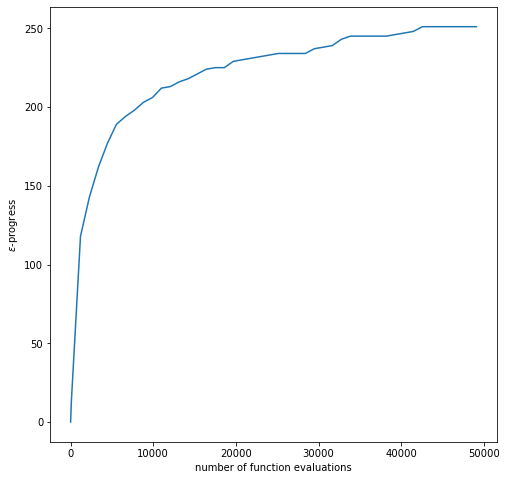

In [56]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,8))
ax.plot(convergence_0.nfe, convergence_0.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations scenario 0')

plt.show()

In [57]:
results_0

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.066645,0.680527,1.816996,0.720498,0.233590,0.329844,0.631620,0.99,1.0
1,0.331538,0.390462,1.679687,0.721191,0.073445,0.169898,0.242729,0.99,1.0
2,0.689882,0.789645,1.483917,0.934381,0.101484,0.349163,0.663636,0.99,1.0
3,0.482472,0.564943,1.982527,0.877670,0.081109,0.229679,0.405958,0.99,1.0
4,0.139470,0.732439,1.936407,0.731837,0.140452,0.362343,0.680375,0.99,1.0
5,0.392266,0.366967,1.984284,0.723798,0.057985,0.159745,0.214632,0.99,1.0
6,0.148984,0.392017,1.850497,0.656995,0.091389,0.179805,0.270399,0.99,1.0
7,0.438961,0.586014,1.769083,0.862203,0.000134,0.249603,0.455341,0.99,1.0
8,1.274776,0.625360,1.871131,0.829063,0.108601,0.289902,0.550393,0.99,1.0
9,0.512348,0.699527,1.765241,0.888610,0.138504,0.299977,0.571978,0.99,1.0


In [59]:
%%time

results_1_file = "results/results_1.csv"
convergence_1_file = "results/convergence_1.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_1 = pd.read_csv("results/results_1.csv")
    convergence_1 = pd.read_csv("results/convergence_1.csv")
except IOError:
    with MultiprocessingEvaluator(model) as evaluator:
        results_1, convergence_1 = evaluator.optimize(nfe=50000, searchover='levers', convergence = convergence_metrics, reference=reference[1],
                                 epsilons=[0.01,]*len(model.outcomes))
          
    results_1.to_csv("results/results_1.csv")
    convergence_1.to_csv("results/convergence_1.csv")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 995/50000 nfe
[MainProcess/INFO] generation 15: 1490/50000 nfe
[MainProcess/INFO] generation 20: 1987/50000 nfe
[MainProcess/INFO] generation 25: 2482/50000 nfe
[MainProcess/INFO] generation 30: 2979/50000 nfe
[MainProcess/INFO] generation 35: 3472/50000 nfe
[MainProcess/INFO] generation 40: 3966/50000 nfe
[MainProcess/INFO] generation 45: 4464/50000 nfe
[MainProcess/INFO] generation 50: 4958/50000 nfe
[MainProcess/INFO] generation 55: 5451/50000 nfe
[MainProcess/INFO] generation 60: 5949/50000 nfe
[MainProcess/INFO] generation 65: 6446/50000 nfe
[MainProcess/INFO] generation 70: 6943/50000 nfe
[MainProcess/INFO] generation 75: 7436/50000 nfe
[MainProcess/INFO] generation 80: 7930/50000 nfe
[MainProcess/INFO] generation 85: 8426/50000 nfe
[MainProcess/INFO] generation 90: 8925/50000 nfe
[MainProcess/INFO] generation 95: 9419/50000

Wall time: 12min 15s


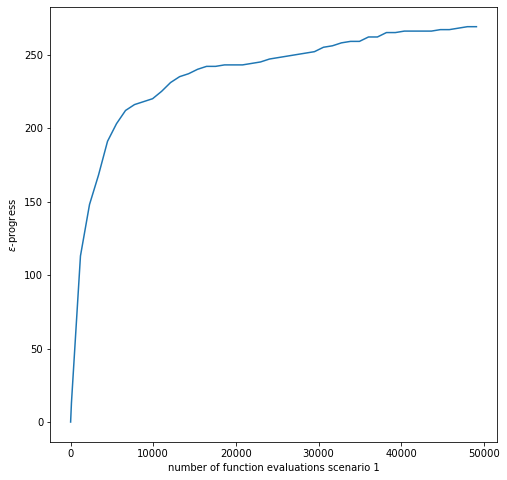

In [62]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,8))
ax.plot(convergence_1.nfe, convergence_1.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations scenario 1')

plt.show()

In [63]:
results_1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.647738,0.782646,0.652413,1.009411,0.350368,0.338818,0.604742,0.99,1.0
1,0.505463,0.654488,1.776825,0.851141,0.031291,0.289975,0.521501,0.99,1.0
2,0.613792,0.582021,1.560490,0.823369,0.100380,0.248788,0.436312,0.99,1.0
3,0.756049,0.781679,0.549234,1.210774,0.132341,0.346863,0.615534,0.99,1.0
4,0.585311,0.236556,0.927379,0.561889,0.056710,0.129988,0.145889,0.99,1.0
5,0.733250,0.737127,0.919928,1.042214,0.449462,0.308443,0.555822,0.99,1.0
6,0.480624,0.393529,0.592752,0.690013,0.122620,0.189204,0.296543,0.99,1.0
7,0.179890,0.562441,0.936905,0.798291,0.139652,0.239003,0.414830,0.99,1.0
8,0.353821,0.752348,1.160446,0.805602,0.137735,0.359875,0.630114,0.99,1.0
9,0.132977,0.393955,0.527609,0.582399,0.324498,0.179968,0.273593,0.99,1.0


In [64]:
%%time

results_2_file = "results/results_2.csv"
convergence_2_file = "results/convergence_2.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_2 = pd.read_csv("results/results_2.csv")
    convergence_2 = pd.read_csv("results/convergence_2.csv")
except IOError:
    with MultiprocessingEvaluator(model) as evaluator:
        results_2, convergence_2 = evaluator.optimize(nfe=50000, searchover='levers', convergence = convergence_metrics, reference=reference[2],
                                 epsilons=[0.01,]*len(model.outcomes))
          
    results_2.to_csv("results/results_2.csv")
    convergence_2.to_csv("results/convergence_2.csv")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 989/50000 nfe
[MainProcess/INFO] generation 15: 1485/50000 nfe
[MainProcess/INFO] generation 20: 1977/50000 nfe
[MainProcess/INFO] generation 25: 2464/50000 nfe
[MainProcess/INFO] generation 30: 2959/50000 nfe
[MainProcess/INFO] generation 35: 3454/50000 nfe
[MainProcess/INFO] generation 40: 3950/50000 nfe
[MainProcess/INFO] generation 45: 4445/50000 nfe
[MainProcess/INFO] generation 50: 4939/50000 nfe
[MainProcess/INFO] generation 55: 5435/50000 nfe
[MainProcess/INFO] generation 60: 5927/50000 nfe
[MainProcess/INFO] generation 65: 6418/50000 nfe
[MainProcess/INFO] generation 70: 6917/50000 nfe
[MainProcess/INFO] generation 75: 7415/50000 nfe
[MainProcess/INFO] generation 80: 7913/50000 nfe
[MainProcess/INFO] generation 85: 8405/50000 nfe
[MainProcess/INFO] generation 90: 8903/50000 nfe
[MainProcess/INFO] generation 95: 9398/50000

Wall time: 13min 56s


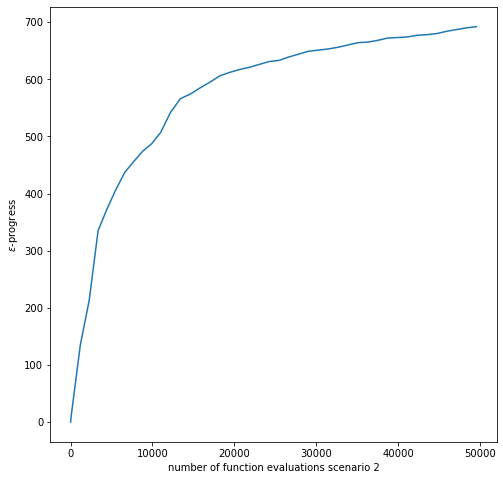

In [65]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,8))
ax.plot(convergence_2.nfe, convergence_2.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations scenario 2')

plt.show()

In [66]:
results_2

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.273849,0.279285,1.518454,0.227614,0.379818,0.223929,0.173005,0.9900,1.0000
1,1.007637,0.338343,1.993306,0.082302,0.250937,3.234744,0.373401,0.9869,0.6462
2,-0.080445,0.338395,1.169642,0.079388,0.193382,4.153816,0.422537,0.9852,0.5327
3,0.569264,0.338395,0.903788,0.079388,0.184735,2.697907,0.350091,0.9592,0.7095
4,0.913498,0.342969,1.782106,0.072557,0.167929,6.299466,0.540484,0.9806,0.2680
...,...,...,...,...,...,...,...,...,...
82,0.662460,0.343354,1.844247,0.078354,0.170736,4.844013,0.460357,0.9643,0.4505
83,0.640279,0.343537,1.709346,0.076497,0.565593,1.396993,0.280184,0.9739,0.8701
84,0.943843,0.338414,1.579841,0.081181,0.093502,4.077334,0.420462,0.9755,0.5412
85,0.204185,0.339996,1.745123,0.082872,0.214218,3.309670,0.380896,0.9535,0.6353


In [67]:
%%time

results_3_file = "results/results_3.csv"
convergence_3_file = "results/convergence_3.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_3 = pd.read_csv("results/results_3.csv")
    convergence_3 = pd.read_csv("results/convergence_3.csv")
except IOError:
    with MultiprocessingEvaluator(model) as evaluator:
        results_3, convergence_3 = evaluator.optimize(nfe=50000, searchover='levers', convergence = convergence_metrics, reference=reference[3],
                                 epsilons=[0.01,]*len(model.outcomes))
          
    results_3.to_csv("results/results_3.csv")
    convergence_3.to_csv("results/convergence_3.csv")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 497/50000 nfe
[MainProcess/INFO] generation 10: 994/50000 nfe
[MainProcess/INFO] generation 15: 1489/50000 nfe
[MainProcess/INFO] generation 20: 1986/50000 nfe
[MainProcess/INFO] generation 25: 2484/50000 nfe
[MainProcess/INFO] generation 30: 2982/50000 nfe
[MainProcess/INFO] generation 35: 3476/50000 nfe
[MainProcess/INFO] generation 40: 3969/50000 nfe
[MainProcess/INFO] generation 45: 4468/50000 nfe
[MainProcess/INFO] generation 50: 4961/50000 nfe
[MainProcess/INFO] generation 55: 5456/50000 nfe
[MainProcess/INFO] generation 60: 5950/50000 nfe
[MainProcess/INFO] generation 65: 6446/50000 nfe
[MainProcess/INFO] generation 70: 6943/50000 nfe
[MainProcess/INFO] generation 75: 7438/50000 nfe
[MainProcess/INFO] generation 80: 7932/50000 nfe
[MainProcess/INFO] generation 85: 8427/50000 nfe
[MainProcess/INFO] generation 90: 8919/50000 nfe
[MainProcess/INFO] generation 95: 9416/50000

Wall time: 14min 49s


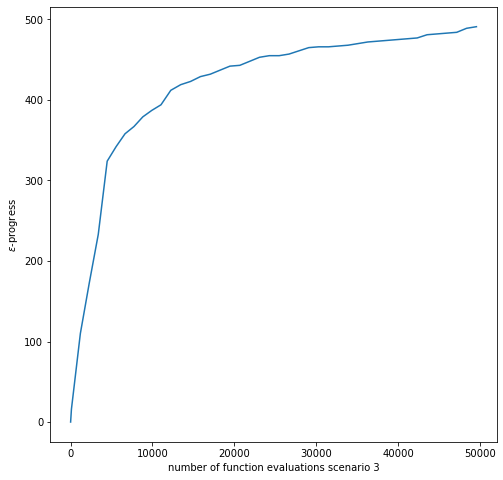

In [68]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,8))
ax.plot(convergence_3.nfe, convergence_3.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations scenario 3')

plt.show()

In [69]:
results_3

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.376122,-0.758083,1.565303,1.519230,0.794303,3.982523,0.518898,0.9900,0.0928
1,0.413492,0.237909,1.919743,0.054063,0.759162,1.724966,0.372171,0.9841,0.6220
2,0.350454,0.235756,0.751031,0.054063,0.696079,2.703036,0.491017,0.9858,0.3755
3,0.435655,0.235756,1.832558,0.054128,0.485852,3.681721,0.620468,0.9878,0.1250
4,0.350454,0.235756,0.751031,0.054063,0.696079,2.477388,0.466390,0.9856,0.4308
...,...,...,...,...,...,...,...,...,...
69,0.496641,0.225031,1.487131,0.041728,0.794770,0.967052,0.281117,0.9828,0.8118
70,0.462112,0.222724,1.210246,0.187524,0.735528,0.174693,0.183351,0.9900,1.0000
71,-0.133843,0.223595,1.608312,0.045186,0.698718,1.041772,0.290124,0.9858,0.7929
72,0.557961,0.225741,1.535001,0.046024,0.765260,0.703524,0.250421,0.9883,0.8779


In [47]:
# %%time

# results_test_file = "results/results_test.csv"
# convergence_test_file = "results/convergence_test.csv"

# try:
#     # Only run the experiments again if data hasn't been generated yet
#     results_test = pd.read_csv("results/results_test.csv")
#     convergence_test = pd.read_csv("results/convergence_test.csv")
# except IOError:
#     with MultiprocessingEvaluator(model) as evaluator:
#         results_test, convergence_test = evaluator.optimize(nfe=10000, searchover='levers', convergence = convergence_metrics,
#                                  epsilons=[0.01,]*len(model.outcomes))
          
#     results_test.to_csv("results/results_test.csv")
#     convergence_test.to_csv("results/convergence_test.csv")

# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
# ax1.plot(convergence_test.nfe, convergence_test.epsilon_progress)
# ax1.set_ylabel('$\epsilon$-progress')
# ax2.plot(convergence_test.nfe, convergence_test.hypervolume)
# ax2.set_ylabel('hypervolume')

# ax1.set_xlabel('number of function evaluations')
# ax2.set_xlabel('number of function evaluations')
# plt.show()

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=1000, searchover='levers', convergence = convergence_metrics,
                                 epsilons=[0.01,]*len(model.outcomes))

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [81]:
results = pd.concat([results_0, results_1, results_2, results_3])
# Only Policies with reliabilty higher than 90%
results = results[results["reliability"] > 0.9]
# Sort on max utility
results = results.sort_values(by=["utility"], ascending=False)
results = results.reset_index(drop=True)
results = results[:50]
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.139470,0.732439,1.936407,0.731837,0.140452,0.362343,0.680375,0.9900,1.0000
1,0.544591,0.757380,1.508835,0.841392,0.089422,0.357023,0.674533,0.9900,1.0000
2,0.689882,0.789645,1.483917,0.934381,0.101484,0.349163,0.663636,0.9900,1.0000
3,1.050547,0.726518,1.977901,0.841315,0.131709,0.337741,0.645467,0.9900,1.0000
4,0.066645,0.680527,1.816996,0.720498,0.233590,0.329844,0.631620,0.9900,1.0000
5,0.353821,0.752348,1.160446,0.805602,0.137735,0.359875,0.630114,0.9900,1.0000
6,0.756049,0.781679,0.549234,1.210774,0.132341,0.346863,0.615534,0.9900,1.0000
7,0.665296,0.746020,1.644257,0.938127,0.095022,0.319827,0.612800,0.9900,1.0000
8,0.647738,0.782646,0.652413,1.009411,0.350368,0.338818,0.604742,0.9900,1.0000
9,0.684128,0.724525,1.949228,0.923092,0.100469,0.309968,0.593222,0.9900,1.0000


In [83]:
policy_df = results[['c1', 'c2', 'r1', 'r2', 'w1']]
policy_dict = policy_df.to_dict(orient='records')

policies = []
for i in range(len(policy_dict)):
    policies.append(Policy(str(i), **policy_dict[i]))

In [85]:
fn = "Ass_9_1000scenarios.tar.gz"

try:
    # Only run the experiments again if data hasn't been generated yet
    results = load_results(fn)
except IOError:
    with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(scenarios=1000, policies=policies, uncertainty_sampling='lhs')
    save_results(results, fn)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 50 policies * 1 model(s) = 50000 experiments
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 35000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 45000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\archipel-03\Documents\GitHub\MBDM\Week 5-6 - robustness and direct search\Ass_9_1000scenarios.tar.gz


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?
